In [1]:
# importing required libraries 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter("ignore")

In [2]:
result_df = pd.read_csv('../input/formula-1-world-championship-1950-2020/results.csv')
stats_df = pd.read_csv('../input/formula-1-world-championship-1950-2020/status.csv')
drivers_df = pd.read_csv('../input/formula-1-world-championship-1950-2020/drivers.csv')
races_df = pd.read_csv('../input/formula-1-world-championship-1950-2020/races.csv')
constructor_df = pd.read_csv('../input/formula-1-world-championship-1950-2020/constructors.csv')
driver_standings_df = pd.read_csv('../input/formula-1-world-championship-1950-2020/driver_standings.csv')
pd.get_option("display.max_columns",None)

20

In [3]:
result_df.head() 

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [4]:
stats_df.head() 

,statusId,status
0,1,Finished
1,2,Disqualified
2,3,Accident
3,4,Collision
4,5,Engine


In [5]:
drivers_df.head() 

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [6]:
races_df.head() 

,raceId,year,round,circuitId,name,date,time,url
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...


In [7]:
constructor_df.head() 

,constructorId,constructorRef,name,nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
3,4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
4,5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso


In [8]:
driver_standings_df.head() 

,driverStandingsId,raceId,driverId,points,position,positionText,wins
0,1,18,1,10.0,1,1,1
1,2,18,2,8.0,2,2,0
2,3,18,3,6.0,3,3,0
3,4,18,4,5.0,4,4,0
4,5,18,5,4.0,5,5,0


In [9]:
# merging all seperate dataframe into single dataframe as df

con1 = pd.merge(result_df, races_df, on ='raceId')
con2 = pd.merge(con1, drivers_df, on = 'driverId')
con3 = pd.merge(con2, driver_standings_df, on = 'driverId')
con4 = pd.merge(con3, constructor_df, on ='constructorId')
df = pd.merge(con4, stats_df, on ='statusId')
pd.get_option("display.max_columns",None)
df.head()

,resultId,raceId_x,driverId,constructorId,number_x,grid,position_x,positionText_x,positionOrder,points_x,...,raceId_y,points_y,position_y,positionText_y,wins,constructorRef,name_y,nationality_y,url,status
0,1,18,1,1,22,1,1,1,1,10.0,...,18,10.0,1,1,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,Finished
1,1,18,1,1,22,1,1,1,1,10.0,...,19,14.0,1,1,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,Finished
2,1,18,1,1,22,1,1,1,1,10.0,...,20,14.0,3,3,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,Finished
3,1,18,1,1,22,1,1,1,1,10.0,...,21,20.0,2,2,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,Finished
4,1,18,1,1,22,1,1,1,1,10.0,...,22,28.0,3,3,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren,Finished


In [10]:
# checking of null values

df.isna().sum()

resultId             0
raceId_x             0
driverId             0
constructorId        0
number_x             0
grid                 0
position_x           0
positionText_x       0
positionOrder        0
points_x             0
laps                 0
time_x               0
milliseconds         0
fastestLap           0
rank                 0
fastestLapTime       0
fastestLapSpeed      0
statusId             0
year                 0
round                0
circuitId            0
name_x               0
date                 0
time_y               0
url_x                0
driverRef            0
number_y             0
code                 0
forename             0
surname              0
dob                  0
nationality_x        0
url_y                0
driverStandingsId    0
raceId_y             0
points_y             0
position_y           0
positionText_y       0
wins                 0
constructorRef       0
name_y               0
nationality_y        0
url                  0
status     

In [11]:
# There's no null values in the dataset

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3348650 entries, 0 to 3348649
Data columns (total 44 columns):
 #   Column             Dtype  
---  ------             -----  
 0   resultId           int64  
 1   raceId_x           int64  
 2   driverId           int64  
 3   constructorId      int64  
 4   number_x           object 
 5   grid               int64  
 6   position_x         object 
 7   positionText_x     object 
 8   positionOrder      int64  
 9   points_x           float64
 10  laps               int64  
 11  time_x             object 
 12  milliseconds       object 
 13  fastestLap         object 
 14  rank               object 
 15  fastestLapTime     object 
 16  fastestLapSpeed    object 
 17  statusId           int64  
 18  year               int64  
 19  round              int64  
 20  circuitId          int64  
 21  name_x             object 
 22  date               object 
 23  time_y             object 
 24  url_x              object 
 25  driverRef         

In [13]:
# summary
df.describe().T  

,count,mean,std,min,25%,50%,75%,max
resultId,3348650.0,12007.688474,7901.419969,1.0,4814.0,11080.0,20391.0,25404.0
raceId_x,3348650.0,490.572793,315.901639,1.0,223.0,445.0,775.0,1073.0
driverId,3348650.0,183.326989,241.487947,1.0,20.0,102.0,207.0,854.0
constructorId,3348650.0,37.409320,54.292359,1.0,6.0,17.0,35.0,214.0
grid,3348650.0,9.811387,6.601276,0.0,4.0,9.0,15.0,34.0
positionOrder,3348650.0,11.336113,7.437479,1.0,5.0,10.0,17.0,39.0
points_x,3348650.0,2.810254,5.112221,0.0,0.0,0.0,4.0,50.0
laps,3348650.0,48.012672,25.461189,0.0,31.0,54.0,67.0,200.0
statusId,3348650.0,13.494156,22.501670,1.0,1.0,5.0,12.0,139.0
year,3348650.0,1995.139344,16.882719,1950.0,1983.0,1997.0,2010.0,2021.0


In [14]:
df.columns

Index(['resultId', 'raceId_x', 'driverId', 'constructorId', 'number_x', 'grid',
       'position_x', 'positionText_x', 'positionOrder', 'points_x', 'laps',
       'time_x', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'year', 'round', 'circuitId', 'name_x',
       'date', 'time_y', 'url_x', 'driverRef', 'number_y', 'code', 'forename',
       'surname', 'dob', 'nationality_x', 'url_y', 'driverStandingsId',
       'raceId_y', 'points_y', 'position_y', 'positionText_y', 'wins',
       'constructorRef', 'name_y', 'nationality_y', 'url', 'status'],
      dtype='object')

In [15]:
# droping unwanted columns 

df = df.drop(['url','url_x','position_x','fastestLapTime','positionText_x','time_x','time_y','driverRef',
              'constructorRef','nationality_y','url_y','positionText_y','raceId_y','points_y'],1)

In [16]:
# changing of old column name to meaningful name 

col_name = {'number_x':'number','milliseconds':'timetaken_in_millisec','fastestLapSpeed':'max_speed',
 'name_x':'grand_prix','number_y':'driver_num','code':'driver_code','nationality_x':'nationality','name_y':'company',
 'raceId_x':'racerId','points_x':'points','position_y':'position'}

df.rename(columns=col_name,inplace=True)
df.head()

,resultId,racerId,driverId,constructorId,number,grid,positionOrder,points,laps,timetaken_in_millisec,...,driver_code,forename,surname,dob,nationality,driverStandingsId,position,wins,company,status
0,1,18,1,1,22,1,1,10.0,58,5690616,...,HAM,Lewis,Hamilton,1985-01-07,British,1,1,1,McLaren,Finished
1,1,18,1,1,22,1,1,10.0,58,5690616,...,HAM,Lewis,Hamilton,1985-01-07,British,9,1,1,McLaren,Finished
2,1,18,1,1,22,1,1,10.0,58,5690616,...,HAM,Lewis,Hamilton,1985-01-07,British,27,3,1,McLaren,Finished
3,1,18,1,1,22,1,1,10.0,58,5690616,...,HAM,Lewis,Hamilton,1985-01-07,British,48,2,1,McLaren,Finished
4,1,18,1,1,22,1,1,10.0,58,5690616,...,HAM,Lewis,Hamilton,1985-01-07,British,69,3,1,McLaren,Finished


In [17]:
# Adding two column (forename,surname) to create a single column called driver_name

df['driver_name'] = df['forename']+' '+df['surname']

In [18]:
df = df.drop(['forename','surname'],1)

In [19]:
# converting to date format from string 

pd.to_datetime(df.date)

0         2008-03-16
1         2008-03-16
2         2008-03-16
3         2008-03-16
4         2008-03-16
             ...    
3348645   1951-05-30
3348646   1951-05-30
3348647   1951-05-30
3348648   1951-05-30
3348649   1951-05-30
Name: date, Length: 3348650, dtype: datetime64[ns]

In [20]:
df['dob'] = pd.to_datetime(df['dob'])
df['date'] = pd.to_datetime(df['date'])

In [21]:
from datetime import datetime

In [22]:
# calculating driver's age and creating it as a new column

dates = datetime.today()-df['dob']
age = dates.dt.days/365

In [23]:
df['age'] = round(age)

In [24]:
pd.set_option('display.max_columns', None)
df.head()

,resultId,racerId,driverId,constructorId,number,grid,positionOrder,points,laps,timetaken_in_millisec,fastestLap,rank,max_speed,statusId,year,round,circuitId,grand_prix,date,driver_num,driver_code,dob,nationality,driverStandingsId,position,wins,company,status,driver_name,age
0,1,18,1,1,22,1,1,10.0,58,5690616,39,2,218.300,1,2008,1,1,Australian Grand Prix,2008-03-16,44,HAM,1985-01-07,British,1,1,1,McLaren,Finished,Lewis Hamilton,37.0
1,1,18,1,1,22,1,1,10.0,58,5690616,39,2,218.300,1,2008,1,1,Australian Grand Prix,2008-03-16,44,HAM,1985-01-07,British,9,1,1,McLaren,Finished,Lewis Hamilton,37.0
2,1,18,1,1,22,1,1,10.0,58,5690616,39,2,218.300,1,2008,1,1,Australian Grand Prix,2008-03-16,44,HAM,1985-01-07,British,27,3,1,McLaren,Finished,Lewis Hamilton,37.0
3,1,18,1,1,22,1,1,10.0,58,5690616,39,2,218.300,1,2008,1,1,Australian Grand Prix,2008-03-16,44,HAM,1985-01-07,British,48,2,1,McLaren,Finished,Lewis Hamilton,37.0
4,1,18,1,1,22,1,1,10.0,58,5690616,39,2,218.300,1,2008,1,1,Australian Grand Prix,2008-03-16,44,HAM,1985-01-07,British,69,3,1,McLaren,Finished,Lewis Hamilton,37.0


In [25]:
# changing datatype

l = ['number','timetaken_in_millisec','fastestLap','rank','max_speed','driver_num']
for i in l:
    df[i] = pd.to_numeric(df[i],errors='coerce')

In [26]:
df.drop('driver_num',1,inplace=True)

In [27]:
# seperating categorical and numerical columns for understading 

cat = []
num = []
for i in df.columns:
    if df[i].dtypes == 'O':
        cat.append(i)
    else:
        num.append(i)

In [28]:
df[cat].head()

,grand_prix,driver_code,nationality,company,status,driver_name
0,Australian Grand Prix,HAM,British,McLaren,Finished,Lewis Hamilton
1,Australian Grand Prix,HAM,British,McLaren,Finished,Lewis Hamilton
2,Australian Grand Prix,HAM,British,McLaren,Finished,Lewis Hamilton
3,Australian Grand Prix,HAM,British,McLaren,Finished,Lewis Hamilton
4,Australian Grand Prix,HAM,British,McLaren,Finished,Lewis Hamilton


In [29]:
df[num].head()

,resultId,racerId,driverId,constructorId,number,grid,positionOrder,points,laps,timetaken_in_millisec,fastestLap,rank,max_speed,statusId,year,round,circuitId,date,dob,driverStandingsId,position,wins,age
0,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.3,1,2008,1,1,2008-03-16,1985-01-07,1,1,1,37.0
1,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.3,1,2008,1,1,2008-03-16,1985-01-07,9,1,1,37.0
2,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.3,1,2008,1,1,2008-03-16,1985-01-07,27,3,1,37.0
3,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.3,1,2008,1,1,2008-03-16,1985-01-07,48,2,1,37.0
4,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.3,1,2008,1,1,2008-03-16,1985-01-07,69,3,1,37.0


In [30]:
df.dtypes

resultId                          int64
racerId                           int64
driverId                          int64
constructorId                     int64
number                          float64
grid                              int64
positionOrder                     int64
points                          float64
laps                              int64
timetaken_in_millisec           float64
fastestLap                      float64
rank                            float64
max_speed                       float64
statusId                          int64
year                              int64
round                             int64
circuitId                         int64
grand_prix                       object
date                     datetime64[ns]
driver_code                      object
dob                      datetime64[ns]
nationality                      object
driverStandingsId                 int64
position                          int64
wins                              int64


In [31]:
df.head()

,resultId,racerId,driverId,constructorId,number,grid,positionOrder,points,laps,timetaken_in_millisec,fastestLap,rank,max_speed,statusId,year,round,circuitId,grand_prix,date,driver_code,dob,nationality,driverStandingsId,position,wins,company,status,driver_name,age
0,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.3,1,2008,1,1,Australian Grand Prix,2008-03-16,HAM,1985-01-07,British,1,1,1,McLaren,Finished,Lewis Hamilton,37.0
1,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.3,1,2008,1,1,Australian Grand Prix,2008-03-16,HAM,1985-01-07,British,9,1,1,McLaren,Finished,Lewis Hamilton,37.0
2,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.3,1,2008,1,1,Australian Grand Prix,2008-03-16,HAM,1985-01-07,British,27,3,1,McLaren,Finished,Lewis Hamilton,37.0
3,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.3,1,2008,1,1,Australian Grand Prix,2008-03-16,HAM,1985-01-07,British,48,2,1,McLaren,Finished,Lewis Hamilton,37.0
4,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.3,1,2008,1,1,Australian Grand Prix,2008-03-16,HAM,1985-01-07,British,69,3,1,McLaren,Finished,Lewis Hamilton,37.0


In [32]:
df.isnull().sum() / len(df) * 100

resultId                  0.000000
racerId                   0.000000
driverId                  0.000000
constructorId             0.000000
number                    0.004778
grid                      0.000000
positionOrder             0.000000
points                    0.000000
laps                      0.000000
timetaken_in_millisec    62.912039
fastestLap               63.678706
rank                     62.794858
max_speed                63.678706
statusId                  0.000000
year                      0.000000
round                     0.000000
circuitId                 0.000000
grand_prix                0.000000
date                      0.000000
driver_code               0.000000
dob                       0.000000
nationality               0.000000
driverStandingsId         0.000000
position                  0.000000
wins                      0.000000
company                   0.000000
status                    0.000000
driver_name               0.000000
age                 

In [33]:
df['max_speed'].mean()

203.57074483026804

In [34]:
df[['rank','fastestLap']] = df[['rank','fastestLap']].fillna(0)
df['timetaken_in_millisec'] = df['timetaken_in_millisec'].fillna(df['timetaken_in_millisec'].mean())
df['max_speed']= df['max_speed'].fillna(df['max_speed'].mean())
df['number'] = df['number'].fillna(0)

In [35]:
df.isnull().sum() / len(df) * 100

resultId                 0.0
racerId                  0.0
driverId                 0.0
constructorId            0.0
number                   0.0
grid                     0.0
positionOrder            0.0
points                   0.0
laps                     0.0
timetaken_in_millisec    0.0
fastestLap               0.0
rank                     0.0
max_speed                0.0
statusId                 0.0
year                     0.0
round                    0.0
circuitId                0.0
grand_prix               0.0
date                     0.0
driver_code              0.0
dob                      0.0
nationality              0.0
driverStandingsId        0.0
position                 0.0
wins                     0.0
company                  0.0
status                   0.0
driver_name              0.0
age                      0.0
dtype: float64

In [36]:
df.head()

,resultId,racerId,driverId,constructorId,number,grid,positionOrder,points,laps,timetaken_in_millisec,fastestLap,rank,max_speed,statusId,year,round,circuitId,grand_prix,date,driver_code,dob,nationality,driverStandingsId,position,wins,company,status,driver_name,age
0,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.3,1,2008,1,1,Australian Grand Prix,2008-03-16,HAM,1985-01-07,British,1,1,1,McLaren,Finished,Lewis Hamilton,37.0
1,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.3,1,2008,1,1,Australian Grand Prix,2008-03-16,HAM,1985-01-07,British,9,1,1,McLaren,Finished,Lewis Hamilton,37.0
2,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.3,1,2008,1,1,Australian Grand Prix,2008-03-16,HAM,1985-01-07,British,27,3,1,McLaren,Finished,Lewis Hamilton,37.0
3,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.3,1,2008,1,1,Australian Grand Prix,2008-03-16,HAM,1985-01-07,British,48,2,1,McLaren,Finished,Lewis Hamilton,37.0
4,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.3,1,2008,1,1,Australian Grand Prix,2008-03-16,HAM,1985-01-07,British,69,3,1,McLaren,Finished,Lewis Hamilton,37.0


In [37]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
resultId,3348650.0,1.200769e+04,7901.419969,1.00,4.814000e+03,1.108000e+04,2.039100e+04,25404.00
racerId,3348650.0,4.905728e+02,315.901639,1.00,2.230000e+02,4.450000e+02,7.750000e+02,1073.00
driverId,3348650.0,1.833270e+02,241.487947,1.00,2.000000e+01,1.020000e+02,2.070000e+02,854.00
constructorId,3348650.0,3.740932e+01,54.292359,1.00,6.000000e+00,1.700000e+01,3.500000e+01,214.00
number,3348650.0,1.490537e+01,13.265392,0.00,6.000000e+00,1.100000e+01,2.100000e+01,208.00
grid,3348650.0,9.811387e+00,6.601276,0.00,4.000000e+00,9.000000e+00,1.500000e+01,34.00
positionOrder,3348650.0,1.133611e+01,7.437479,1.00,5.000000e+00,1.000000e+01,1.700000e+01,39.00
points,3348650.0,2.810254e+00,5.112221,0.00,0.000000e+00,0.000000e+00,4.000000e+00,50.00
laps,3348650.0,4.801267e+01,25.461189,0.00,3.100000e+01,5.400000e+01,6.700000e+01,200.00
timetaken_in_millisec,3348650.0,5.952802e+06,742532.014494,207071.00,5.952802e+06,5.952802e+06,5.952802e+06,15090540.00


In [38]:
circuit_df = pd.read_csv('../input/formula-1-world-championship-1950-2020/circuits.csv')
circuit_df.head()

,circuitId,circuitRef,name,location,country,lat,lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...
3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcel...
4,5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park


In [39]:
# ploting the f1 track using lat and lng in worldmap

import folium
coordinates=[]
for lat,lng in zip(circuit_df['lat'],circuit_df['lng']):
    coordinates.append([lat,lng])
maps = folium.Map(zoom_start=2,tiles='Stamen Watercolor')  #map_types (Stamen Terrain, Stamen Toner, Mapbox Bright, cartodbpositron)
for i,j in zip(coordinates,circuit_df.name):
    marker = folium.Marker(
        location=i,
        icon=folium.Icon(icon="star",color='cadetblue'),
        popup="<strong>{0}</strong>".format(j))  #strong is used to bold the font (optional)
    marker.add_to(maps)
maps

In [40]:
df['rank'].unique()

array([ 2.,  3.,  6.,  5.,  4., 11.,  1., 12., 15., 10.,  9.,  8.,  7.,
       18., 19., 13., 17.,  0., 14., 16., 20., 21., 22., 23., 24.])

Filtering data by the driver who finished the race successfully

In [41]:
df_fin = df[df['status'] == 'Finished']
df_fin.tail()

,resultId,racerId,driverId,constructorId,number,grid,positionOrder,points,laps,timetaken_in_millisec,fastestLap,rank,max_speed,statusId,year,round,circuitId,grand_prix,date,driver_code,dob,nationality,driverStandingsId,position,wins,company,status,driver_name,age
1240921,23346,967,839,209,31.0,22,12,0.0,71,10907144.0,47.0,16.0,176.686,1,2016,20,18,Brazilian Grand Prix,2016-11-13,OCO,1996-09-17,French,70668,11,1,Manor Marussia,Finished,Esteban Ocon,25.0
1240922,23346,967,839,209,31.0,22,12,0.0,71,10907144.0,47.0,16.0,176.686,1,2016,20,18,Brazilian Grand Prix,2016-11-13,OCO,1996-09-17,French,70689,11,1,Manor Marussia,Finished,Esteban Ocon,25.0
1240923,23346,967,839,209,31.0,22,12,0.0,71,10907144.0,47.0,16.0,176.686,1,2016,20,18,Brazilian Grand Prix,2016-11-13,OCO,1996-09-17,French,70731,11,1,Manor Marussia,Finished,Esteban Ocon,25.0
1240924,23346,967,839,209,31.0,22,12,0.0,71,10907144.0,47.0,16.0,176.686,1,2016,20,18,Brazilian Grand Prix,2016-11-13,OCO,1996-09-17,French,70752,11,1,Manor Marussia,Finished,Esteban Ocon,25.0
1240925,23346,967,839,209,31.0,22,12,0.0,71,10907144.0,47.0,16.0,176.686,1,2016,20,18,Brazilian Grand Prix,2016-11-13,OCO,1996-09-17,French,70770,10,0,Manor Marussia,Finished,Esteban Ocon,25.0


In [42]:
mean = df.max_speed.mean()
mean2 = df.fastestLap.mean()
df = df_fin[df_fin['max_speed']>mean]
df.head()

,resultId,racerId,driverId,constructorId,number,grid,positionOrder,points,laps,timetaken_in_millisec,fastestLap,rank,max_speed,statusId,year,round,circuitId,grand_prix,date,driver_code,dob,nationality,driverStandingsId,position,wins,company,status,driver_name,age
0,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.3,1,2008,1,1,Australian Grand Prix,2008-03-16,HAM,1985-01-07,British,1,1,1,McLaren,Finished,Lewis Hamilton,37.0
1,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.3,1,2008,1,1,Australian Grand Prix,2008-03-16,HAM,1985-01-07,British,9,1,1,McLaren,Finished,Lewis Hamilton,37.0
2,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.3,1,2008,1,1,Australian Grand Prix,2008-03-16,HAM,1985-01-07,British,27,3,1,McLaren,Finished,Lewis Hamilton,37.0
3,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.3,1,2008,1,1,Australian Grand Prix,2008-03-16,HAM,1985-01-07,British,48,2,1,McLaren,Finished,Lewis Hamilton,37.0
4,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.3,1,2008,1,1,Australian Grand Prix,2008-03-16,HAM,1985-01-07,British,69,3,1,McLaren,Finished,Lewis Hamilton,37.0


In [43]:
df[df['fastestLap']>mean2]

,resultId,racerId,driverId,constructorId,number,grid,positionOrder,points,laps,timetaken_in_millisec,fastestLap,rank,max_speed,statusId,year,round,circuitId,grand_prix,date,driver_code,dob,nationality,driverStandingsId,position,wins,company,status,driver_name,age
0,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.300,1,2008,1,1,Australian Grand Prix,2008-03-16,HAM,1985-01-07,British,1,1,1,McLaren,Finished,Lewis Hamilton,37.0
1,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.300,1,2008,1,1,Australian Grand Prix,2008-03-16,HAM,1985-01-07,British,9,1,1,McLaren,Finished,Lewis Hamilton,37.0
2,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.300,1,2008,1,1,Australian Grand Prix,2008-03-16,HAM,1985-01-07,British,27,3,1,McLaren,Finished,Lewis Hamilton,37.0
3,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.300,1,2008,1,1,Australian Grand Prix,2008-03-16,HAM,1985-01-07,British,48,2,1,McLaren,Finished,Lewis Hamilton,37.0
4,1,18,1,1,22.0,1,1,10.0,58,5690616.0,39.0,2.0,218.300,1,2008,1,1,Australian Grand Prix,2008-03-16,HAM,1985-01-07,British,69,3,1,McLaren,Finished,Lewis Hamilton,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240785,25389,1073,852,213,22.0,8,4,12.0,58,5423037.0,50.0,7.0,217.285,1,2021,22,24,Abu Dhabi Grand Prix,2021-12-12,TSU,2000-05-11,Japanese,70664,14,0,AlphaTauri,Finished,Yuki Tsunoda,22.0
1240786,25389,1073,852,213,22.0,8,4,12.0,58,5423037.0,50.0,7.0,217.285,1,2021,22,24,Abu Dhabi Grand Prix,2021-12-12,TSU,2000-05-11,Japanese,70685,14,0,AlphaTauri,Finished,Yuki Tsunoda,22.0
1240787,25389,1073,852,213,22.0,8,4,12.0,58,5423037.0,50.0,7.0,217.285,1,2021,22,24,Abu Dhabi Grand Prix,2021-12-12,TSU,2000-05-11,Japanese,70727,14,0,AlphaTauri,Finished,Yuki Tsunoda,22.0
1240788,25389,1073,852,213,22.0,8,4,12.0,58,5423037.0,50.0,7.0,217.285,1,2021,22,24,Abu Dhabi Grand Prix,2021-12-12,TSU,2000-05-11,Japanese,70748,14,0,AlphaTauri,Finished,Yuki Tsunoda,22.0


In [44]:
df.year.unique()

array([2008, 2007, 2009, 2010, 2011, 2012, 2015, 2016, 2017, 2018, 2006,
       2005, 2004, 2013, 2014, 2021, 2019, 2020])

In [45]:
# filtering the data by mean of driver's age and events after year 2012

df = df[(df['age']<df['age'].mean()) & (df['year']>2012)]
df

,resultId,racerId,driverId,constructorId,number,grid,positionOrder,points,laps,timetaken_in_millisec,fastestLap,rank,max_speed,statusId,year,round,circuitId,grand_prix,date,driver_code,dob,nationality,driverStandingsId,position,wins,company,status,driver_name,age
170844,21722,880,815,1,6.0,15,11,0.0,58,5486592.0,46.0,6.0,212.294,1,2013,1,1,Australian Grand Prix,2013-03-17,PER,1990-01-26,Mexican,64406,20,0,McLaren,Finished,Sergio Pérez,32.0
170845,21722,880,815,1,6.0,15,11,0.0,58,5486592.0,46.0,6.0,212.294,1,2013,1,1,Australian Grand Prix,2013-03-17,PER,1990-01-26,Mexican,64430,21,0,McLaren,Finished,Sergio Pérez,32.0
170846,21722,880,815,1,6.0,15,11,0.0,58,5486592.0,46.0,6.0,212.294,1,2013,1,1,Australian Grand Prix,2013-03-17,PER,1990-01-26,Mexican,64454,18,0,McLaren,Finished,Sergio Pérez,32.0
170847,21722,880,815,1,6.0,15,11,0.0,58,5486592.0,46.0,6.0,212.294,1,2013,1,1,Australian Grand Prix,2013-03-17,PER,1990-01-26,Mexican,64478,14,0,McLaren,Finished,Sergio Pérez,32.0
170848,21722,880,815,1,6.0,15,11,0.0,58,5486592.0,46.0,6.0,212.294,1,2013,1,1,Australian Grand Prix,2013-03-17,PER,1990-01-26,Mexican,64502,15,0,McLaren,Finished,Sergio Pérez,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240785,25389,1073,852,213,22.0,8,4,12.0,58,5423037.0,50.0,7.0,217.285,1,2021,22,24,Abu Dhabi Grand Prix,2021-12-12,TSU,2000-05-11,Japanese,70664,14,0,AlphaTauri,Finished,Yuki Tsunoda,22.0
1240786,25389,1073,852,213,22.0,8,4,12.0,58,5423037.0,50.0,7.0,217.285,1,2021,22,24,Abu Dhabi Grand Prix,2021-12-12,TSU,2000-05-11,Japanese,70685,14,0,AlphaTauri,Finished,Yuki Tsunoda,22.0
1240787,25389,1073,852,213,22.0,8,4,12.0,58,5423037.0,50.0,7.0,217.285,1,2021,22,24,Abu Dhabi Grand Prix,2021-12-12,TSU,2000-05-11,Japanese,70727,14,0,AlphaTauri,Finished,Yuki Tsunoda,22.0
1240788,25389,1073,852,213,22.0,8,4,12.0,58,5423037.0,50.0,7.0,217.285,1,2021,22,24,Abu Dhabi Grand Prix,2021-12-12,TSU,2000-05-11,Japanese,70748,14,0,AlphaTauri,Finished,Yuki Tsunoda,22.0


In [46]:
# droping unwanted columns

df.drop('date',1,inplace=True)
df.drop('dob',1,inplace=True)
df.drop('statusId',1,inplace=True)

Checking of skewness in the data, Skewness is used to check the normality of the data by ranging from -1 to 1.
* -1 --> Left skewed 
* 0 --> Normal distribution
* 1 --> Right skewed

In [47]:
df.skew()

resultId                -0.395390
racerId                 -0.438305
driverId                -0.352222
constructorId            0.569431
number                   0.879808
grid                     0.936669
positionOrder            0.836671
points                   0.200778
laps                     0.646558
timetaken_in_millisec    2.913383
fastestLap              -0.186537
rank                     0.804421
max_speed                0.609053
year                    -0.404904
round                    0.017405
circuitId                1.011411
driverStandingsId       -3.317335
position                 0.775866
wins                     2.396299
age                     -0.930818
dtype: float64

Seems some columns are skewed a lot, removal of the outliers will normalize a data bit

In [48]:
# outlier removal 

Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR))).any(axis=1)]
df.head()

,resultId,racerId,driverId,constructorId,number,grid,positionOrder,points,laps,timetaken_in_millisec,fastestLap,rank,max_speed,year,round,circuitId,grand_prix,driver_code,nationality,driverStandingsId,position,wins,company,status,driver_name,age
170844,21722,880,815,1,6.0,15,11,0.0,58,5486592.0,46.0,6.0,212.294,2013,1,1,Australian Grand Prix,PER,Mexican,64406,20,0,McLaren,Finished,Sergio Pérez,32.0
170845,21722,880,815,1,6.0,15,11,0.0,58,5486592.0,46.0,6.0,212.294,2013,1,1,Australian Grand Prix,PER,Mexican,64430,21,0,McLaren,Finished,Sergio Pérez,32.0
170846,21722,880,815,1,6.0,15,11,0.0,58,5486592.0,46.0,6.0,212.294,2013,1,1,Australian Grand Prix,PER,Mexican,64454,18,0,McLaren,Finished,Sergio Pérez,32.0
170847,21722,880,815,1,6.0,15,11,0.0,58,5486592.0,46.0,6.0,212.294,2013,1,1,Australian Grand Prix,PER,Mexican,64478,14,0,McLaren,Finished,Sergio Pérez,32.0
170848,21722,880,815,1,6.0,15,11,0.0,58,5486592.0,46.0,6.0,212.294,2013,1,1,Australian Grand Prix,PER,Mexican,64502,15,0,McLaren,Finished,Sergio Pérez,32.0


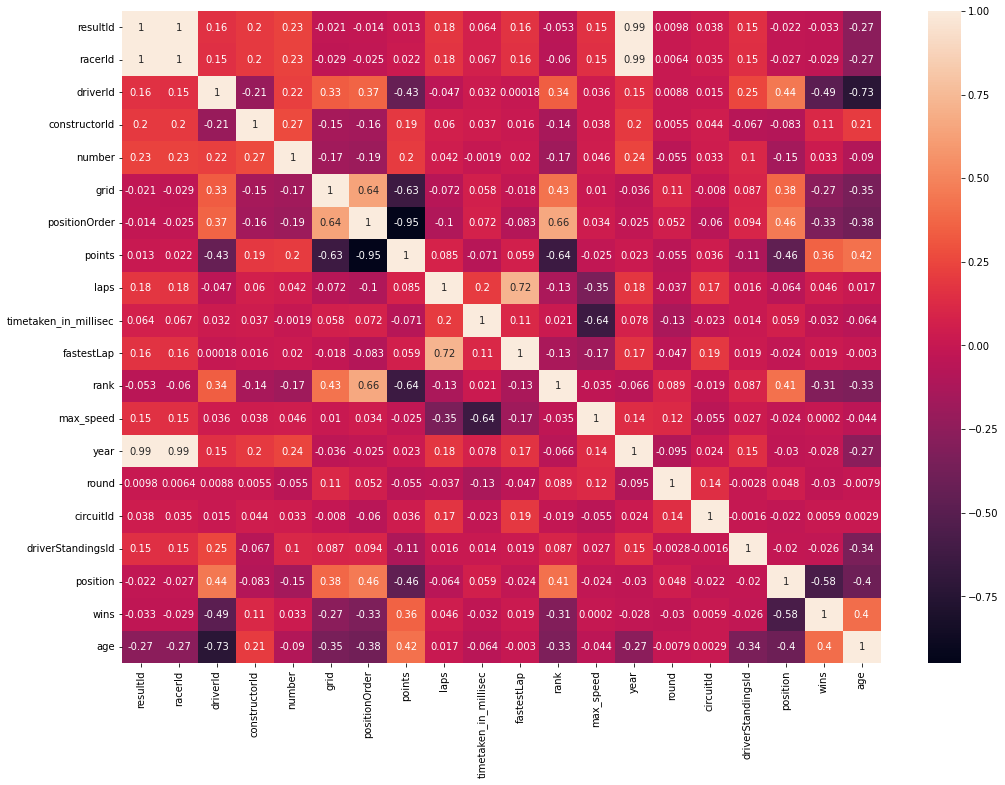

In [49]:
# heatmap

plt.figure(figsize=(17,12))
sns.heatmap(df.corr(),annot=True)
plt.show()

In [50]:
num.remove('date')
num.remove('dob')
num.remove('statusId')

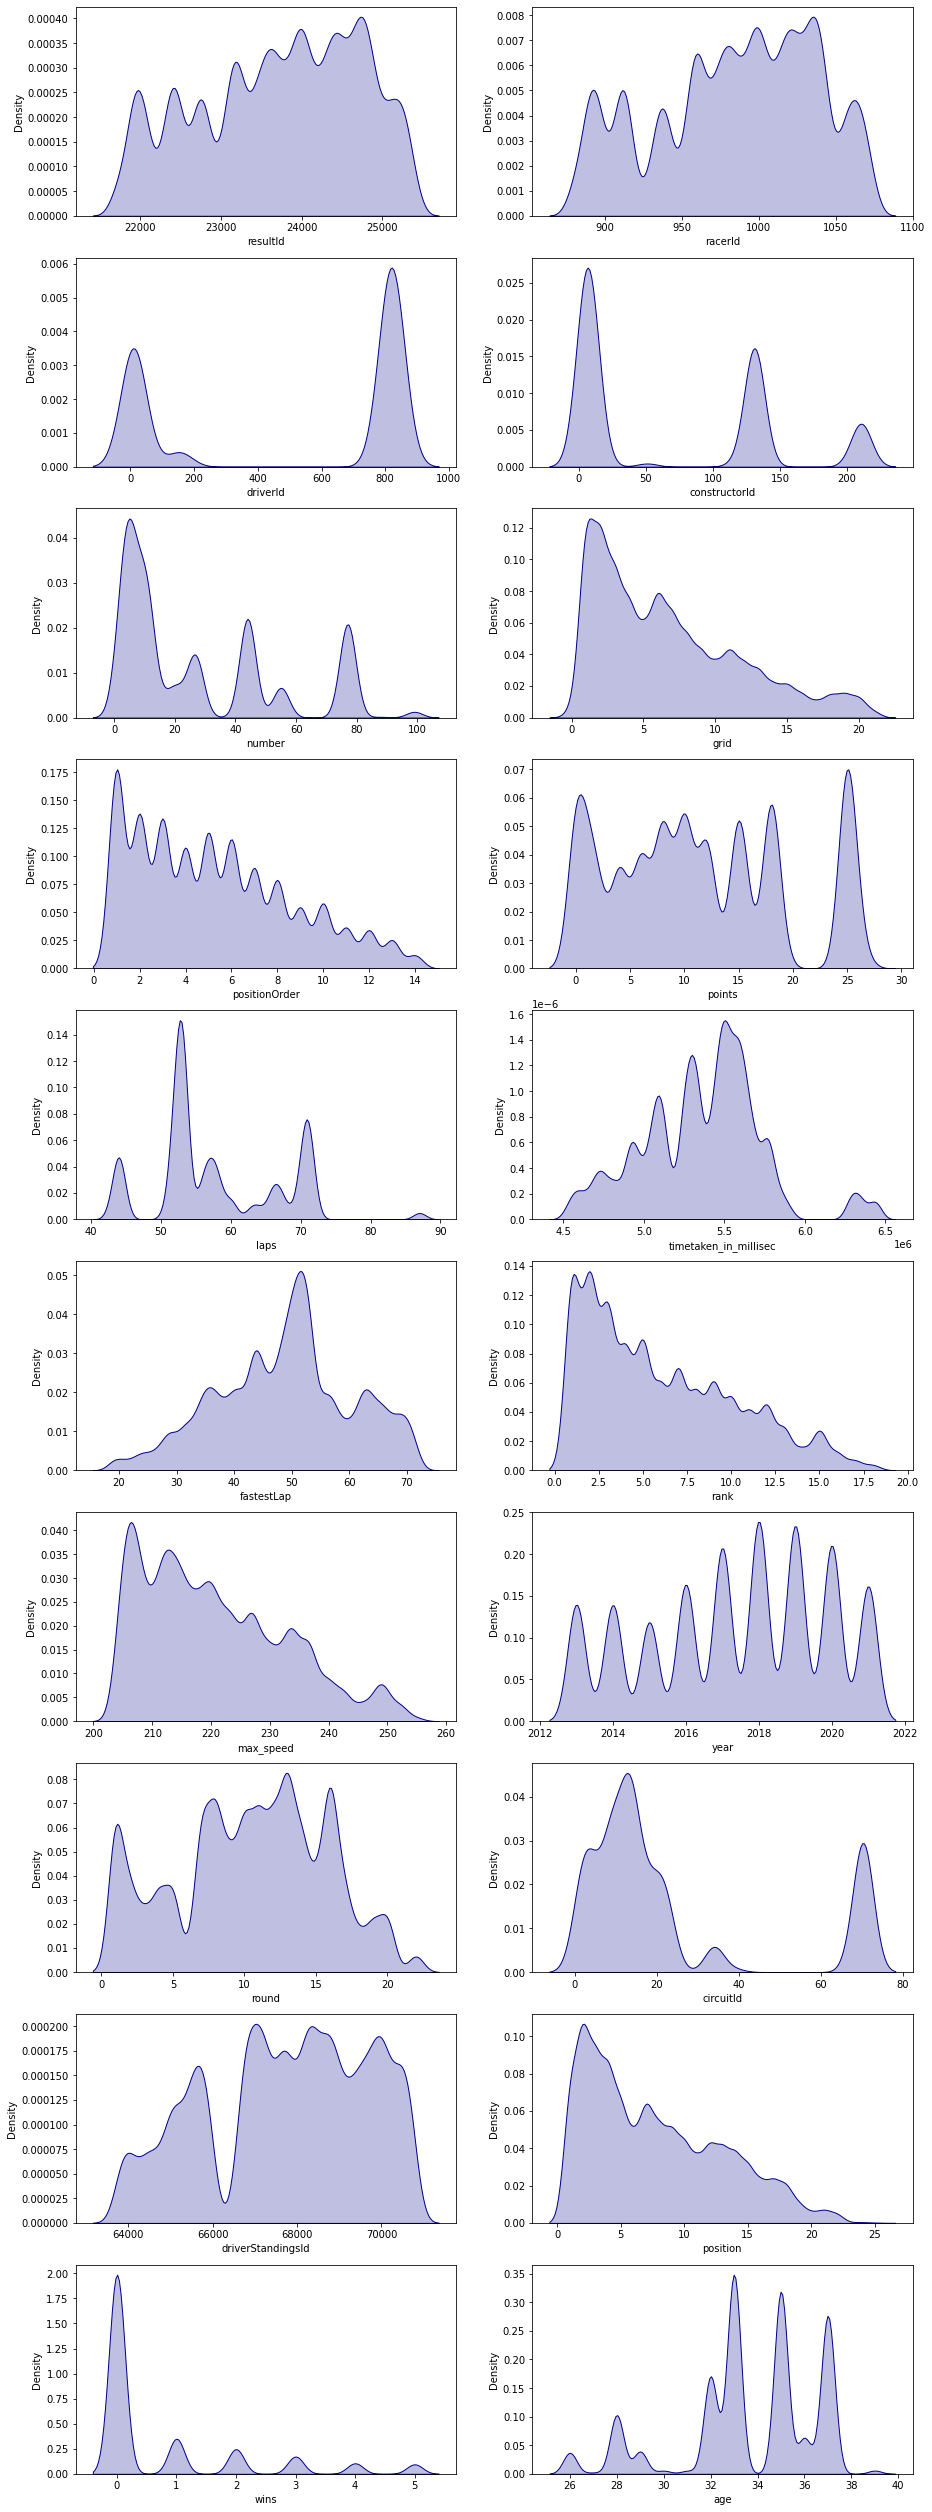

In [51]:
# kde plot for checking the normalization 

plt.figure(figsize=(15,50)) 
for i,j in zip(num,range(1,len(num)+1)):
    plt.subplot(11,2,j)
    sns.kdeplot(df[i],shade=True,color='darkblue')
plt.show()

In [52]:
df.skew()

resultId                -0.286029
racerId                 -0.326222
driverId                -0.421637
constructorId            0.593054
number                   0.909225
grid                     0.865601
positionOrder            0.598116
points                   0.321663
laps                     0.541515
timetaken_in_millisec    0.204111
fastestLap              -0.144312
rank                     0.700541
max_speed                0.640694
year                    -0.282251
round                   -0.152057
circuitId                1.290668
driverStandingsId       -0.309588
position                 0.642377
wins                     1.773129
age                     -0.815264
dtype: float64

Still some columns are skewed even after outlier removal and skewness can be normalized during ML part.

In [53]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [54]:
# encoding categorical columns

for i in cat:
    df[i] = le.fit_transform(df[i])
df.head()

,resultId,racerId,driverId,constructorId,number,grid,positionOrder,points,laps,timetaken_in_millisec,fastestLap,rank,max_speed,year,round,circuitId,grand_prix,driver_code,nationality,driverStandingsId,position,wins,company,status,driver_name,age
170844,21722,880,815,1,6.0,15,11,0.0,58,5486592.0,46.0,6.0,212.294,2013,1,1,2,18,10,64406,20,0,7,0,24,32.0
170845,21722,880,815,1,6.0,15,11,0.0,58,5486592.0,46.0,6.0,212.294,2013,1,1,2,18,10,64430,21,0,7,0,24,32.0
170846,21722,880,815,1,6.0,15,11,0.0,58,5486592.0,46.0,6.0,212.294,2013,1,1,2,18,10,64454,18,0,7,0,24,32.0
170847,21722,880,815,1,6.0,15,11,0.0,58,5486592.0,46.0,6.0,212.294,2013,1,1,2,18,10,64478,14,0,7,0,24,32.0
170848,21722,880,815,1,6.0,15,11,0.0,58,5486592.0,46.0,6.0,212.294,2013,1,1,2,18,10,64502,15,0,7,0,24,32.0


In [55]:
x = df.drop('driver_name',1)
y = df.driver_name

In [56]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3,random_state=42)

In [57]:
# importing ML libraries 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import tree

In [58]:
clf = DecisionTreeClassifier(max_depth=5,random_state=1234)
clf.fit(xtrain, ytrain)

DecisionTreeClassifier(max_depth=5, random_state=1234)

In [59]:
tree.export_text(clf)

'|--- feature_2 <= 2.00\n|   |--- class: 12\n|--- feature_2 >  2.00\n|   |--- feature_17 <= 25.50\n|   |   |--- feature_17 <= 1.50\n|   |   |   |--- feature_17 <= 0.50\n|   |   |   |   |--- class: 1\n|   |   |   |--- feature_17 >  0.50\n|   |   |   |   |--- class: 26\n|   |   |--- feature_17 >  1.50\n|   |   |   |--- feature_18 <= 0.50\n|   |   |   |   |--- class: 5\n|   |   |   |--- feature_18 >  0.50\n|   |   |   |   |--- feature_18 <= 9.50\n|   |   |   |   |   |--- class: 15\n|   |   |   |   |--- feature_18 >  9.50\n|   |   |   |   |   |--- class: 24\n|   |--- feature_17 >  25.50\n|   |   |--- class: 22\n'

In [60]:
fn = list(df.columns)
fn.remove('driver_name')

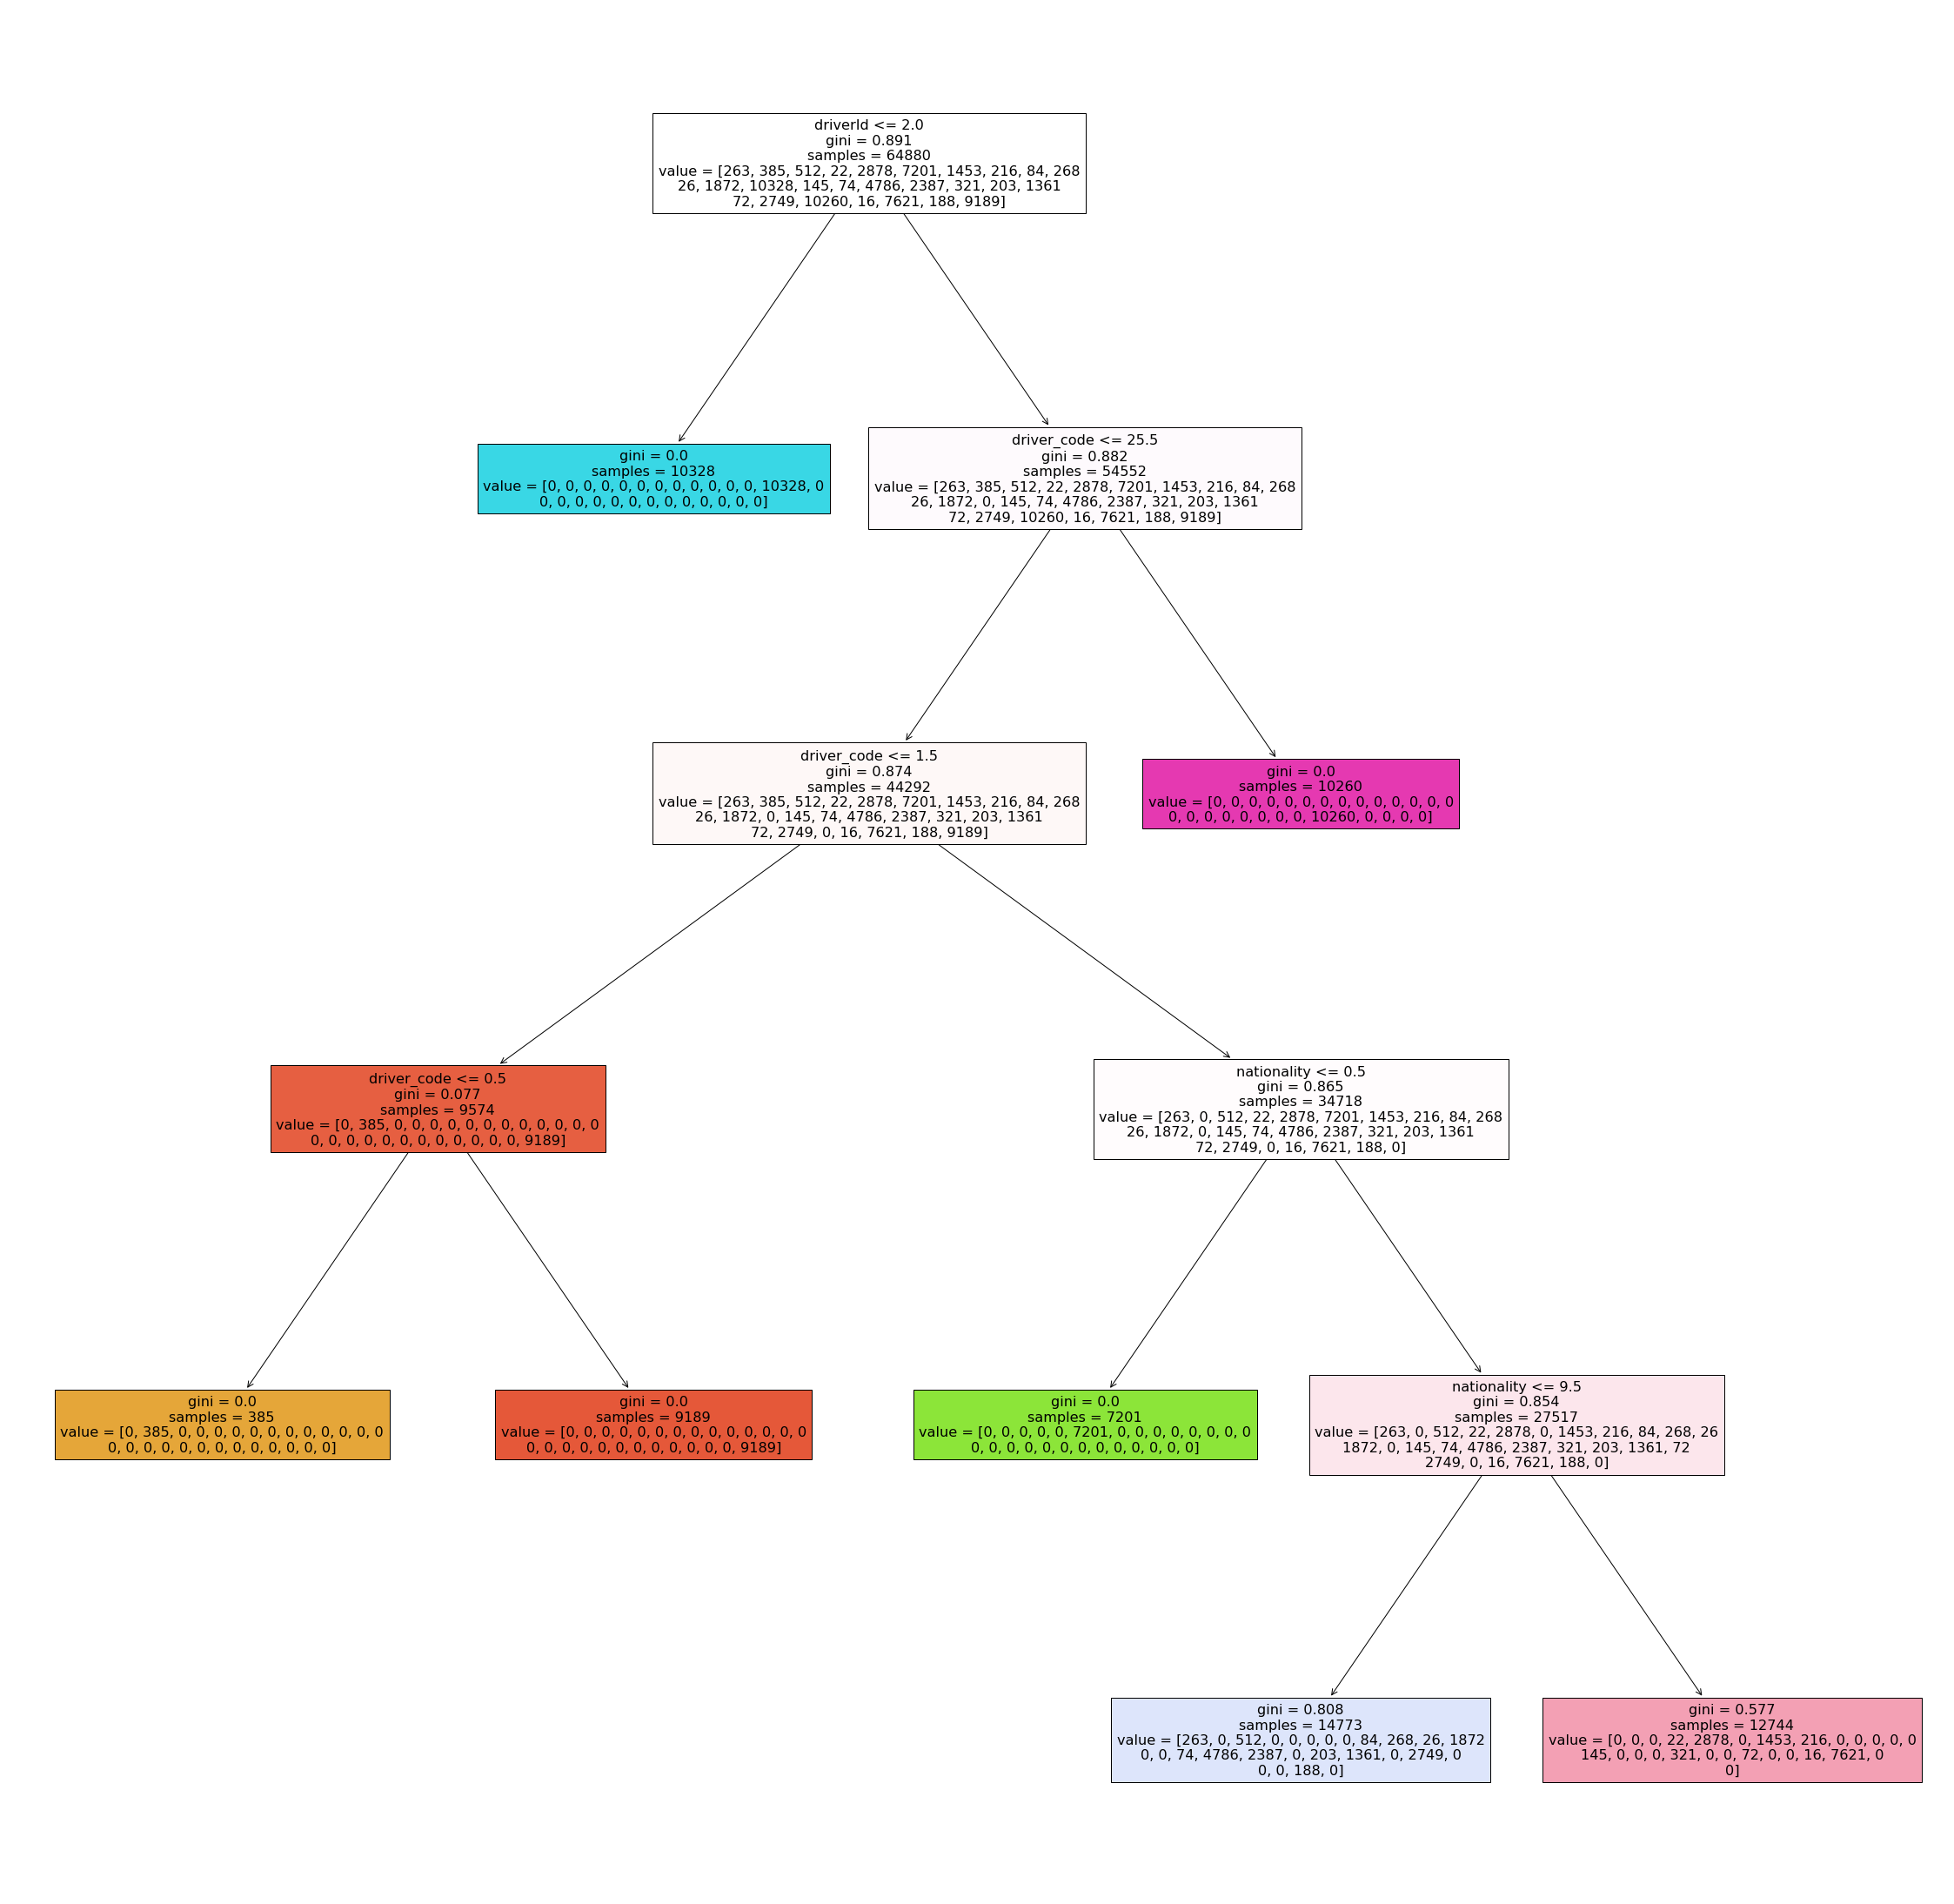

In [61]:
# plotting decision tree workflow 

fig = plt.figure(figsize=(40,40))
_ = tree.plot_tree(clf,
               feature_names=fn,
               filled=True)

In [62]:
# classification ML algorithms 

lr = LogisticRegression(solver='sag')
dt = DecisionTreeClassifier()
rn = RandomForestClassifier()
knn = KNeighborsClassifier()
gb = GaussianNB()
sgd = SGDClassifier()

In [63]:
li = [lr,sgd,knn,gb,rn,dt]
d = {}
for i in li:
    i.fit(xtrain,ytrain)
    ypred = i.predict(xtest)
    print(i,":",accuracy_score(ypred,ytest)*100)
    d.update({str(i):i.score(xtest,ytest)*100})

LogisticRegression(solver='sag') : 19.563419282914374
SGDClassifier() : 15.629158125651815
KNeighborsClassifier() : 99.99640378322006
GaussianNB() : 82.25267019095911
RandomForestClassifier() : 100.0
DecisionTreeClassifier() : 100.0


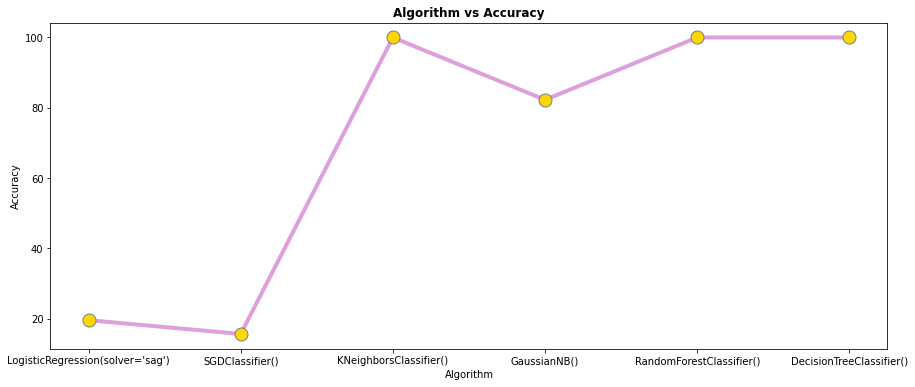

In [64]:
plt.figure(figsize=(15, 6))
plt.title("Algorithm vs Accuracy", fontweight='bold')
plt.xlabel("Algorithm")
plt.ylabel("Accuracy")
plt.plot(d.keys(),d.values(),marker='o',color='plum',linewidth=4,markersize=13,
         markerfacecolor='gold',markeredgecolor='slategray')
plt.show()

As you can see, the accuracy of basic algorithm (logistic) and SGD is not good as expected. Since the data are skewed/denormalized, so it can be fixed by scaling the data.

**[MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)** 

In [65]:
from sklearn.preprocessing import MinMaxScaler
# fit scaler on training data
norm = MinMaxScaler().fit(xtrain)
# transform training data
X_train_norm = norm.transform(xtrain)
# transform testing data
X_test_norm = norm.transform(xtest)

In [66]:
li = [lr,sgd,rn,knn,gb,dt]
di = {}
for i in li:
    i.fit(X_train_norm,ytrain)
    ypred = i.predict(X_test_norm)
    print(i,":",accuracy_score(ypred,ytest)*100)
    di.update({str(i):i.score(X_test_norm,ytest)*100})

LogisticRegression(solver='sag') : 99.97482648254037
SGDClassifier() : 98.88157658143632
RandomForestClassifier() : 100.0
KNeighborsClassifier() : 100.0
GaussianNB() : 100.0
DecisionTreeClassifier() : 100.0


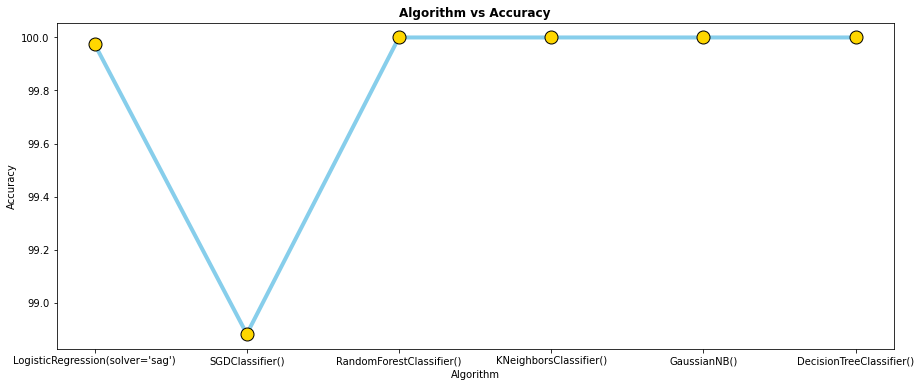

In [67]:
plt.figure(figsize=(15, 6))
plt.title("Algorithm vs Accuracy", fontweight='bold')
plt.xlabel("Algorithm")
plt.ylabel("Accuracy")
plt.plot(di.keys(),di.values(),marker='o',color='skyblue',linewidth=4,markersize=13,
         markerfacecolor='gold',markeredgecolor='black')
plt.show()

As you can see the accuracy are getting high for Logistic Regression and SGDClassifier, both the algorithms are performing well from bottom low to 99% accuracy by scaling. Hence this prove the importance of normalizing the data.

**[StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)** 

In [68]:
from sklearn.preprocessing import StandardScaler
# fit scaler on training data
std = StandardScaler().fit(xtrain)
# transform train data
x_train_std = std.transform(xtrain)
# transform test data
x_test_std = std.transform(xtest)

In [69]:
li = [lr,sgd,rn,knn,gb,dt]
dic = {}
for i in li:
    i.fit(x_train_std,ytrain)
    ypred = i.predict(x_test_std)
    print(i,":",accuracy_score(ypred,ytest)*100)
    dic.update({str(i):i.score(x_test_std,ytest)*100})

LogisticRegression(solver='sag') : 100.0
SGDClassifier() : 99.29873772791024
RandomForestClassifier() : 100.0
KNeighborsClassifier() : 100.0
GaussianNB() : 100.0
DecisionTreeClassifier() : 100.0


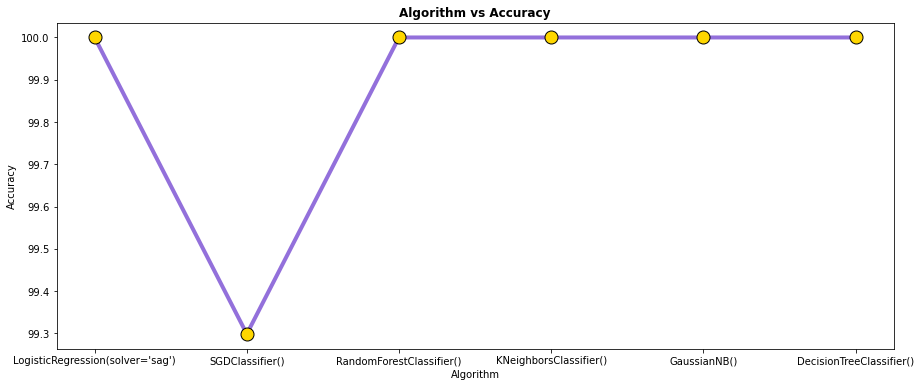

In [70]:
plt.figure(figsize=(15, 6))
plt.title("Algorithm vs Accuracy", fontweight='bold')
plt.xlabel("Algorithm")
plt.ylabel("Accuracy")
plt.plot(dic.keys(),dic.values(),marker='o',color='mediumpurple',linewidth=4,markersize=13,
         markerfacecolor='gold',markeredgecolor='black')
plt.show()

**[RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)**

In [71]:
from sklearn.preprocessing import RobustScaler
# fit scaler on train data
scaler = RobustScaler().fit(xtrain)
# transform train data
xtrain_scaled = scaler.transform(xtrain)
# transform test data
xtest_scaled = scaler.transform(xtest)

In [72]:
li = [lr,sgd,rn,knn,gb,dt]
dics = {}
for i in li:
    i.fit(xtrain_scaled,ytrain)
    ypred = i.predict(xtest_scaled)
    print(i,":",accuracy_score(ypred,ytest)*100)
    dics.update({str(i):i.score(xtest_scaled,ytest)*100})

LogisticRegression(solver='sag') : 100.0
SGDClassifier() : 99.51810695148704
RandomForestClassifier() : 100.0
KNeighborsClassifier() : 100.0
GaussianNB() : 100.0
DecisionTreeClassifier() : 100.0


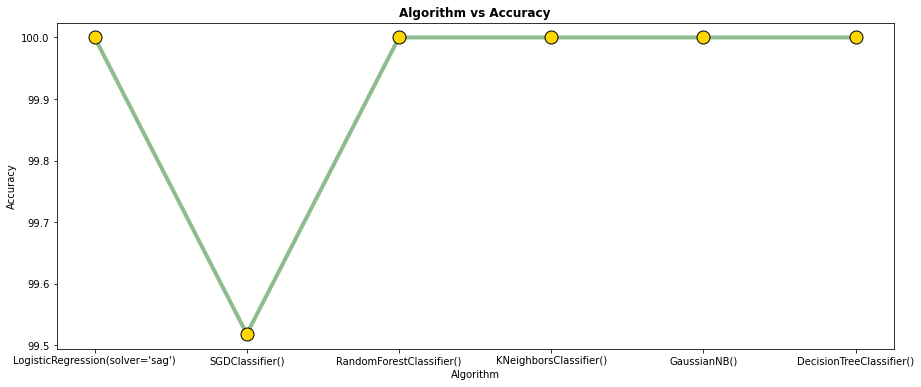

In [73]:
plt.figure(figsize=(15, 6))
plt.title("Algorithm vs Accuracy", fontweight='bold')
plt.xlabel("Algorithm")
plt.ylabel("Accuracy")
plt.plot(dics.keys(),dics.values(),marker='o',color='darkseagreen',linewidth=4,markersize=13,
         markerfacecolor='gold',markeredgecolor='black')
plt.show()

After several stages of scaling process, got a good accuracy score of 100% in all algorithms except SGDClassifier with least of 99.5% for RobustScaler. Even the least (SGDClassifier) is considered as a very good accuracy.

If you enjoyed my work give me an upvote, which will really encourage me to work more like this. Do follow me on social meadia, for more coding and explanation of concept in Data Science and Big Data:
*     linkedin : https://www.linkedin.com/in/anandaram-g/
*     Medium : https://medium.com/@anandlab
*     Github : https://github.com/anand-lab-172
